In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

cf.go_offline()

%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta

In [2]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoCES, AutoETS
from statsforecast.arima import arima_string
import plotly.graph_objects as go
import matplotlib.colors as mcolors

In [3]:
class FixedCESProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        
        self.dfs = []
        self.sf = None
        self.forecast = None
        self.plotting_df = pd.DataFrame()
        
        self.mae = None
        self.mse = None
        self.mape = None
        self.nmse = None
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
    
    def create_fixed_model(self, h, freq, season_length, model_name, level = []):
        self.sf = StatsForecast(models=[AutoCES(season_length=season_length)], freq = freq)
        self.sf.fit(self.dfs[0])
        
        start_date = datetime.strptime(self.dates[0], "%Y-%m-%d")
        ending_date = datetime.strptime(self.dates[-1], "%Y-%m-%d") + timedelta(weeks = h)

        prediction_horizon = abs((ending_date - start_date).days) // 7
        
        if not level:
            self.forecast = self.sf.predict(h = prediction_horizon)
        else:
            self.forecast = self.sf.predict(h = prediction_horizon, level = level)

        self.forecast.set_index("ds", inplace = True)
        self.forecast.drop(columns = "unique_id", inplace = True)
        #self.sf.save(path = f"AutoCES/fixed_models/{model_name}")
        
    
    
    
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if col == "CES":
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['CES'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    
    def create_graph(self):
        if len(self.forecast.columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecast.columns)
    
    
        fig = go.Figure()
        fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))
        
        for col in self.forecast.columns:
            if "hi" in col:
                number = col[-2:]
                fig.add_trace(go.Scatter(x = self.forecast.index, y = self.forecast[col], mode = "lines", name = col,
                                         line = dict(color = self.color_mapping[number])))
                                         
        for col in self.forecast.columns:
            if "lo" in col:
                number = col[-2:]
                fig.add_trace(go.Scatter(x = self.forecast.index, y = self.forecast[col], mode = "lines", name = col,
                                         fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            
        for col in self.forecast.columns:
            if col == "CES":
                fig.add_trace(go.Scatter(x = self.forecast.index, y = self.forecast[col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["CES"])))
        
        fig.update_layout(title = f"Fixed Parameter CES Predictions, {self.dates[0]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
        fig.show()

    
    def create_metrics(self):
        col_string = "CES"

        
        self.mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.nmse = self.mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecast.index])

    def create_metrics_df(self):
        self.metrics_df.loc[len(self.metrics_df)] = [self.dates[0], self.mae, self.mse, self.mape, self.nmse]
    
    def create_display_df(self):
        for index, row in self.forecast.iterrows():
            reference_date = self.dates[0]
            target_end_date = index
            
            for col in self.forecast.columns:
                value = self.forecast.loc[target_end_date, col]
                if "lo" in col:
                    number = int (col[-2:])
                    alpha = 1 - (number / 100)
                    quantile = alpha / 2
                    self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
                if col == "CES":
                    quantile = 0.5
                    self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
                elif "hi" in col:
                    number = int (col[-2:])
                    alpha = 1 - (number / 100)
                    quantile = 1 - (alpha / 2)
                    self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
        
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)

In [4]:
class UpdatingCESProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        
        self.dfs = []
        self.sf = None
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
            
    def create_models(self, h, freq, season_length, model_names, level = []):

        self.sf = StatsForecast(models=[AutoCES(season_length=season_length)], freq = freq)
        
        
        for i in range(len(self.dfs)):
            self.sf.fit(self.dfs[i])
            fc = pd.DataFrame()
            if not level:
                fc = self.sf.predict(h = h)
            else:
                fc = self.sf.predict(h = h, level = level)
            
            fc.set_index("ds", inplace = True)
            fc.drop(columns = "unique_id", inplace = True)
            self.forecasts.append(fc)
            #self.sf.save(path = f"./{self.model_type}/updating_models/{model_names[i]}.ckpt")
    
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if col == "CES":
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['CES'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    def create_graph(self):
        if len(self.forecasts[0].columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecasts[0].columns)
                
        
        for i in range(len(self.forecasts)):
            #Plot the overall Real Data
            fig = go.Figure()
            fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))

            
            for col in self.forecasts[i].columns:
                #Plot his first
                if "hi" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Lows will go to corresponding his
                if "lo" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            for col in self.forecasts[i].columns:
                if col == "CES":
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["CES"])))
                    
            fig.update_layout(title = f"Updating Parameter CES Predictions, {self.dates[i]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
            fig.show()
        
    def calculate_metrics(self):
        col_string = "CES"
  
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def create_metrics_df(self):
        for i in range(len(self.dates)):
            self.metrics_df.loc[len(self.metrics_df)] = [self.dates[i], self.maes[i], self.mses[i], self.mapes[i], self.nmses[i]]
    
    def create_display_df(self):
        for i in range(len(self.forecasts)):
            for index, row in self.forecasts[i].iterrows():
                reference_date = self.dates[i]
                target_end_date = index
                
                for col in self.forecasts[i].columns:
                    value = self.forecasts[i].loc[target_end_date, col]
                    if "lo" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = alpha / 2
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    if col == "CES":
                        quantile = 0.5
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    elif "hi" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = 1 - (alpha / 2)
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)

In [5]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [6]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [7]:
Processor = FixedCESProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [8]:
Processor.create_training_dfs(value_col = "value")

In [9]:
Processor.create_fixed_model(h = 4, freq = "W-SAT", season_length = 52, model_name = "testing", level = [80, 95])

In [10]:
Processor.forecast

,CES,CES-lo-95,CES-lo-80,CES-hi-80,CES-hi-95
ds,,,,,
2024-10-12,262.955078,-3073.665442,-1839.320093,2409.959692,3553.986365
2024-10-19,513.695801,-2783.643335,-1641.464990,2628.435059,3719.264697
2024-10-26,1357.133789,-1792.346191,-737.601416,3424.649194,4533.579419
2024-11-02,2513.559021,-598.024442,487.466113,4552.821094,5754.107263
2024-11-09,3856.770386,774.057645,1837.840308,5876.759326,6960.132251
2024-11-16,5252.757812,2259.414874,3247.967017,7234.435254,8332.662134
2024-11-23,9164.607910,6186.247559,7188.917871,11077.254980,12080.552051
2024-11-30,14169.224365,11320.123779,12296.637402,16059.926953,17057.941699
2024-12-07,13495.920410,10704.292407,11644.453809,15353.423242,16350.878955


/tmp/ipykernel_126893/1272215894.py:60: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



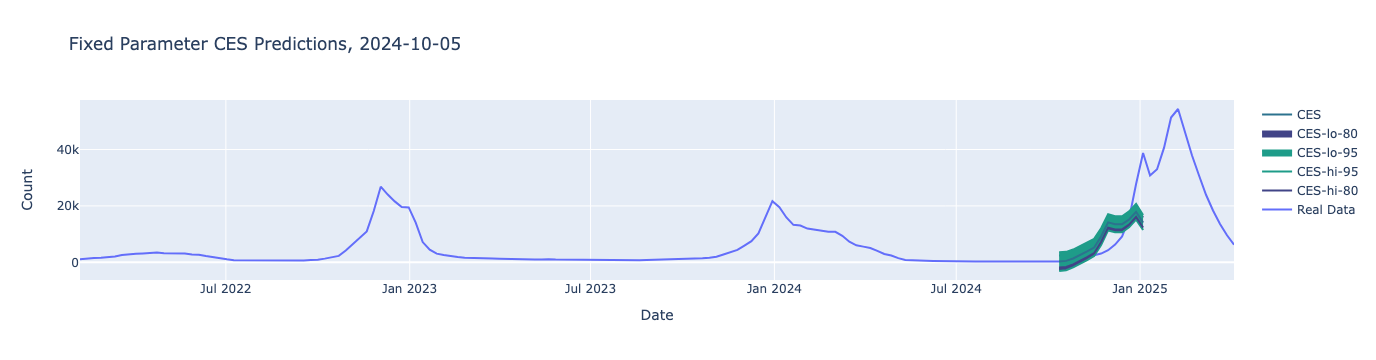

In [11]:
Processor.create_graph()

In [12]:
Processor.create_metrics()

In [13]:
Processor.create_metrics_df()

In [14]:
Processor.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,5276.978051,7.098970e+07,0.83106,0.541012


In [15]:
Processor.create_display_df()

In [16]:
Processor.display_df

,Reference Date,Target End Date,Quantile,Prediction
1,2024-10-05,2024-10-12,0.025,-3073.665442
2,2024-10-05,2024-10-12,0.100,-1839.320093
0,2024-10-05,2024-10-12,0.500,262.955078
3,2024-10-05,2024-10-12,0.900,2409.959692
4,2024-10-05,2024-10-12,0.975,3553.986365
...,...,...,...,...
61,2024-10-05,2025-01-04,0.025,11472.943164
62,2024-10-05,2025-01-04,0.100,12363.104102
60,2024-10-05,2025-01-04,0.500,14094.621338
63,2024-10-05,2025-01-04,0.900,15890.219531


In [17]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [18]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [19]:
UProcessor = UpdatingCESProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [20]:
UProcessor.create_training_dfs(value_col = "value")

In [21]:
UProcessor.create_models(h = 4, freq = "W-SAT", season_length = 52, model_names = ["test1", "test2", "test3", "test4", "test5"], level = [80, 95])

/tmp/ipykernel_126893/2295181086.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



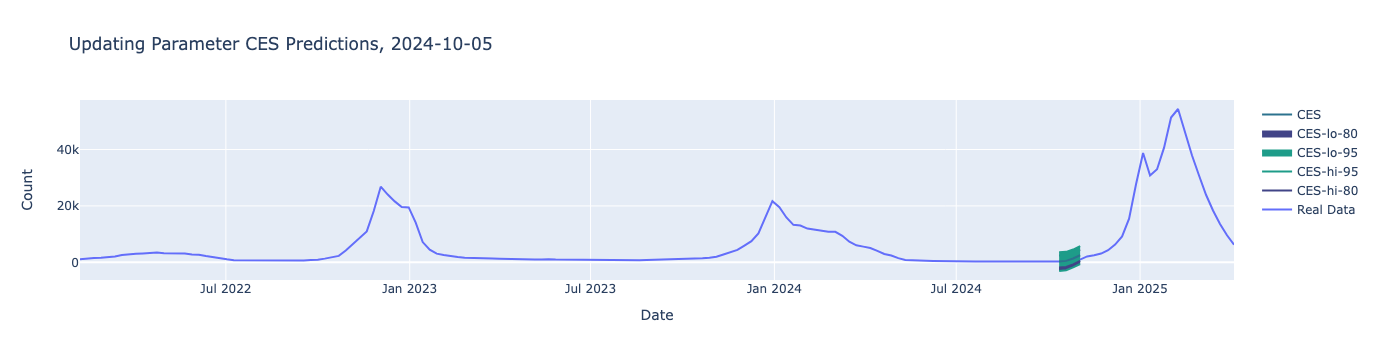

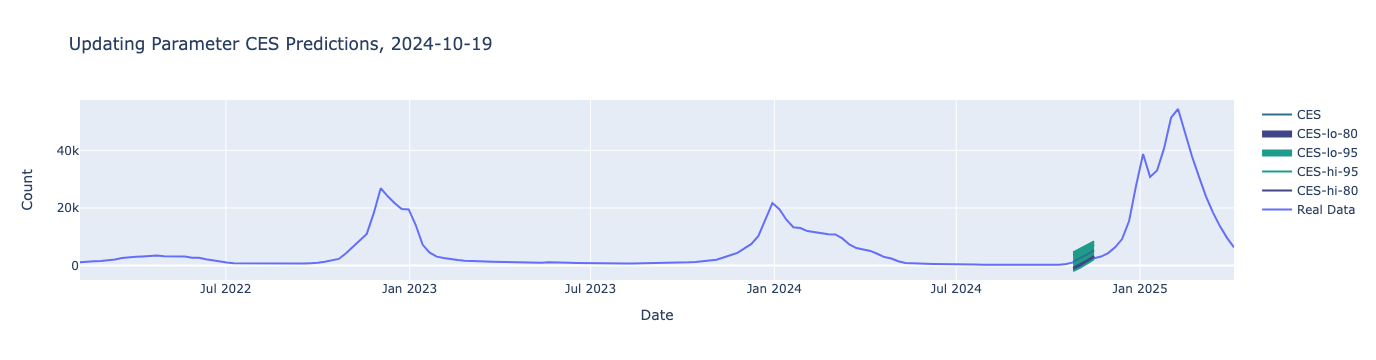

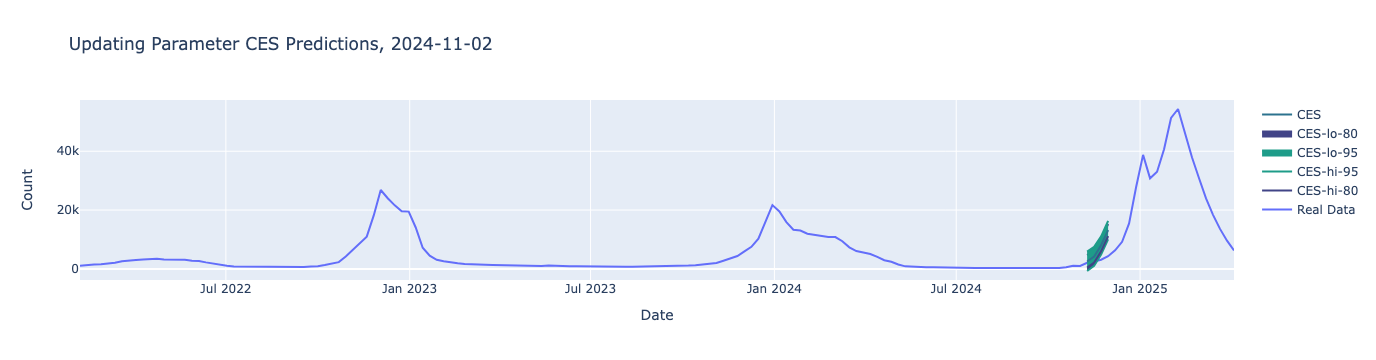

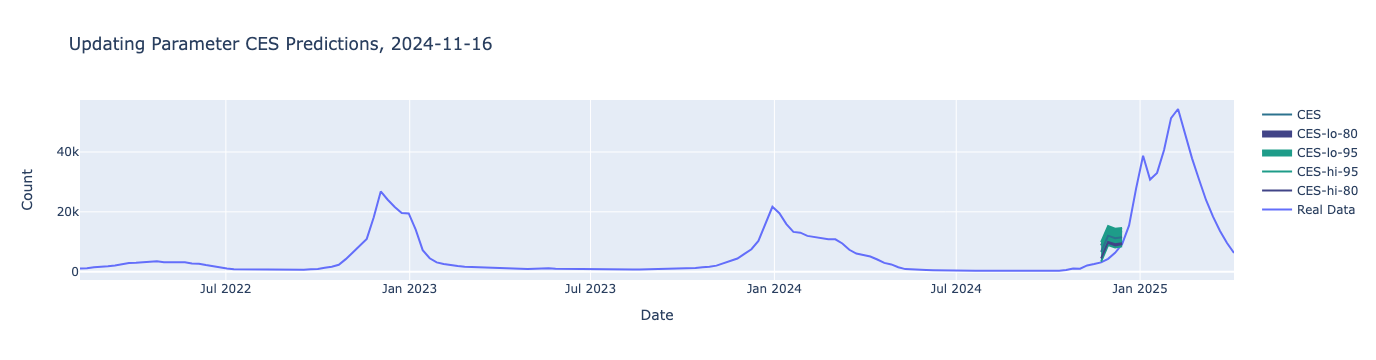

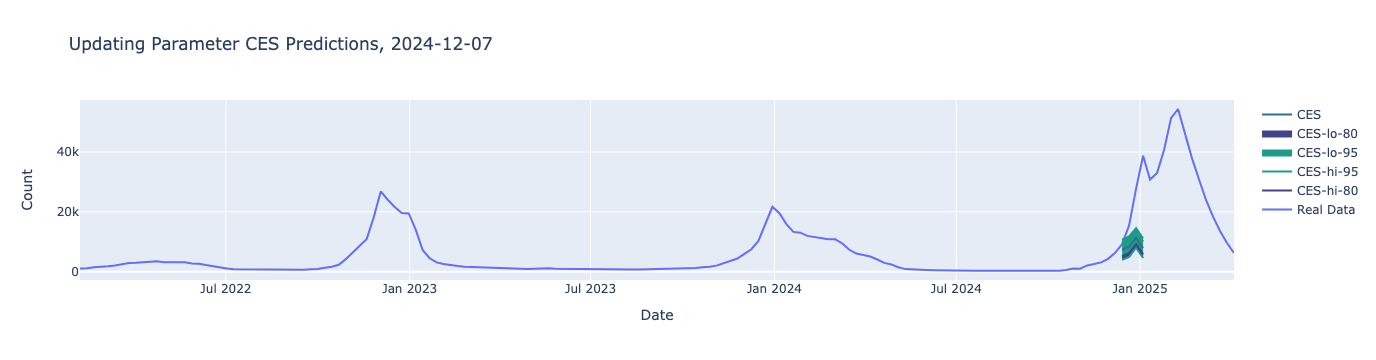

In [22]:
UProcessor.create_graph()

In [23]:
UProcessor.calculate_metrics()

In [24]:
UProcessor.create_metrics_df()

In [25]:
UProcessor.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,470.260483,6.095468e+05,0.501100,5.992859
1,2024-10-19,1594.398972,3.320529e+06,0.950371,7.629941
2,2024-11-02,3990.118988,2.665905e+07,1.134937,38.737924
3,2024-11-16,4619.324928,2.539374e+07,0.992003,4.770151
4,2024-12-07,14071.889099,3.196053e+08,0.512616,2.466194


In [26]:
UProcessor.create_display_df()

In [27]:
UProcessor.display_df

,Reference Date,Target End Date,Quantile,Prediction
1,2024-10-05,2024-10-12,0.025,-3073.665442
2,2024-10-05,2024-10-12,0.100,-1839.320093
0,2024-10-05,2024-10-12,0.500,262.955078
3,2024-10-05,2024-10-12,0.900,2409.959692
4,2024-10-05,2024-10-12,0.975,3553.986365
...,...,...,...,...
96,2024-12-07,2025-01-04,0.025,4564.938062
97,2024-12-07,2025-01-04,0.100,5792.442041
95,2024-12-07,2025-01-04,0.500,7879.287354
98,2024-12-07,2025-01-04,0.900,10022.961328
